In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split  
from torchvision import datasets, models, transforms  
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
resnet_model = models.resnet50(weights='DEFAULT')
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [5]:
class CombinedModel(nn.Module):
    def __init__(self, resnet_model, vit_model, num_classes):
        super(CombinedModel, self).__init__()
        self.resnet = resnet_model
        self.vit = vit_model
        self.fc = nn.Linear(1000 + 1000, num_classes)

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features = self.vit(x).logits
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        return self.fc(combined_features)

In [6]:
model_stage1 = CombinedModel(resnet_model, vit_model, num_classes=2)
model_stage1.load_state_dict(torch.load('healthy_unhealthy_model.pth'))
model_stage1 = model_stage1.to(device)

C:\Users\Dell\AppData\Local\Temp\ipykernel_9896\1394992864.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_stage1.load_state_dict(torch.load('healthy_unhealthy_mod

In [7]:
model_stage2 = CombinedModel(resnet_model, vit_model, num_classes=3)
model_stage2.load_state_dict(torch.load('disease_classification_model.pth'))
model_stage2 = model_stage2.to(device)


C:\Users\Dell\AppData\Local\Temp\ipykernel_9896\461935870.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_stage2.load_state_dict(torch.load('disease_classification

In [8]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(data_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [9]:
stage1_dataset = datasets.ImageFolder(root='Rice 2', transform=transform)
train_size = int(0.8 * len(stage1_dataset))
val_size = len(stage1_dataset) - train_size
train_dataset, val_dataset = random_split(stage1_dataset, [train_size, val_size])
val_loader_stage1 = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
criterion = nn.CrossEntropyLoss()
val_loss_stage1, val_accuracy_stage1 = evaluate_model(model_stage1, val_loader_stage1, criterion)
print(f"Stage 1 - Healthy vs Unhealthy Classification - Validation Loss: {val_loss_stage1:.4f}, Validation Accuracy: {val_accuracy_stage1:.4f}")


Stage 1 - Healthy vs Unhealthy Classification - Validation Loss: 0.1929, Validation Accuracy: 0.9069


In [11]:
stage2_dataset = datasets.ImageFolder(root='Rice 2/Unhealthy', transform=transform)
train_size = int(0.8 * len(stage2_dataset))
val_size = len(stage2_dataset) - train_size
train_dataset, val_dataset = random_split(stage2_dataset, [train_size, val_size])
val_loader_stage2 = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
val_loss_stage2, val_accuracy_stage2 = evaluate_model(model_stage2, val_loader_stage2, criterion)
print(f"Stage 2 - Disease Classification - Validation Loss: {val_loss_stage2:.4f}, Validation Accuracy: {val_accuracy_stage2:.4f}")

Stage 2 - Disease Classification - Validation Loss: 0.2018, Validation Accuracy: 0.9112


In [8]:

full_dataset = datasets.ImageFolder(root='Rice 2', transform=transform)  # Change this to your dataset path
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)



In [9]:
unhealthy_dataset = datasets.ImageFolder(root='Rice 2/Unhealthy', transform=transform)
unhealthy_loader = DataLoader(unhealthy_dataset, batch_size=32, shuffle=False)


In [ ]:
# Evaluate the model on the entire dataset
val_loss_full, val_accuracy_full = evaluate_model(model_stage1, full_loader, criterion)
print(f"Full Dataset - Validation Loss: {val_loss_full:.4f}, Validation Accuracy: {val_accuracy_full:.4f}")

Full Dataset - Validation Loss: 0.1891, Validation Accuracy: 0.9205


In [18]:
val_loss_unhealthy, val_accuracy_unhealthy = evaluate_model(model_stage2, unhealthy_loader, criterion)
print(f"Overall Unhealthy Classification - Validation Loss: {val_loss_unhealthy:.4f}, Validation Accuracy: {val_accuracy_unhealthy:.4f}")

Overall Unhealthy Classification - Validation Loss: 0.1779, Validation Accuracy: 0.9313


In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_with_confusion_matrix(model, data_loader, criterion, num_classes):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(data_loader)
    val_accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))  # Confusion matrix for multi-class
    return val_loss, val_accuracy, cm

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



stage 1 - Validation Loss: 0.1891, Validation Accuracy: 0.9205


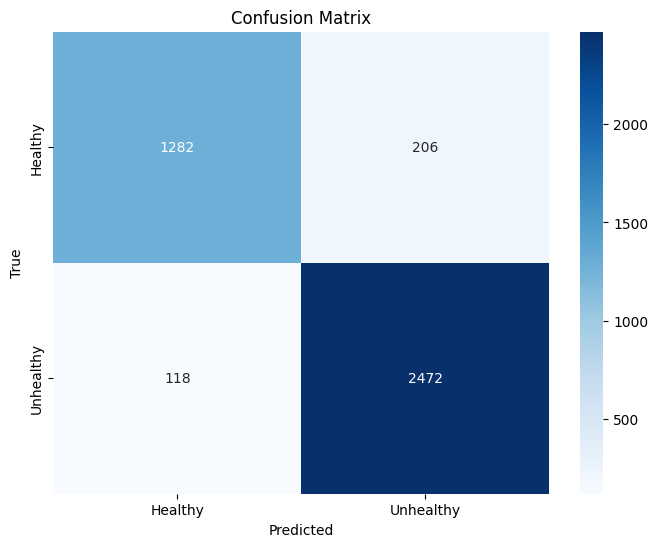

In [12]:
# Stage 1 - Healthy vs Unhealthy Classification
criterion = nn.CrossEntropyLoss()

val_loss_full, val_accuracy_full, cm_full = evaluate_model_with_confusion_matrix(model_stage1, full_loader, criterion, num_classes=2)
print(f"stage 1 - Validation Loss: {val_loss_full:.4f}, Validation Accuracy: {val_accuracy_full:.4f}")
plot_confusion_matrix(cm_full, ['Healthy', 'Unhealthy'])

# Stage 2 - Disease Classification for Unhealthy Leaves



stage 2 - Validation Loss: 0.1779, Validation Accuracy: 0.9313


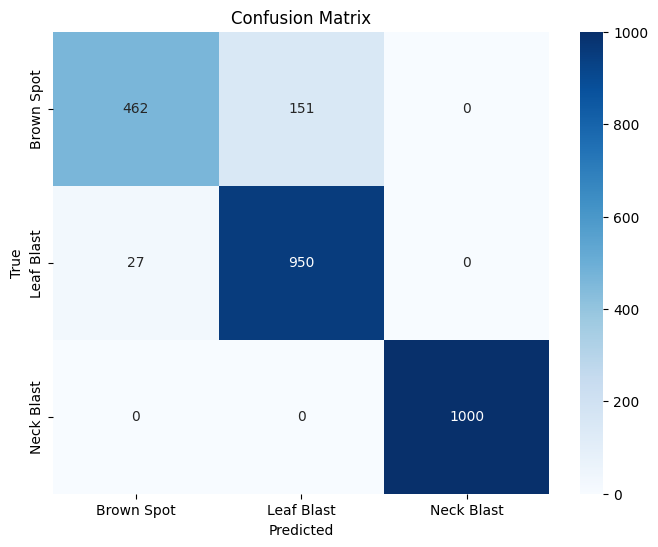

In [13]:
val_loss_unhealthy, val_accuracy_unhealthy, cm_unhealthy = evaluate_model_with_confusion_matrix(model_stage2, unhealthy_loader, criterion, num_classes=3)
print(f"stage 2 - Validation Loss: {val_loss_unhealthy:.4f}, Validation Accuracy: {val_accuracy_unhealthy:.4f}")
plot_confusion_matrix(cm_unhealthy, ['Brown Spot', 'Leaf Blast', 'Neck Blast'])

In [ ]:
val_loss_unhealthy, val_accuracy_unhealthy, cm_unhealthy = evaluate_model_with_confusion_matrix(model_stage2, unhealthy_loader, criterion, num_classes=3)
print(f"stage 2 - Validation Loss: {val_loss_unhealthy:.4f}, Validation Accuracy: {val_accuracy_unhealthy:.4f}")
plot_confusion_matrix(cm_unhealthy, ['Brown Spot', 'Leaf Blast', 'Neck Blast'])

In [1]:
import os

# Define the paths to each subcategory folder
dataset_paths = {
    "Healthy": "Rice 2/Healthy",
    "Brown Spot": "Rice 2/Unhealthy/Brown_Spot",
    "Leaf Blast": "Rice 2/Unhealthy/Leaf_Blast",
    "Neck Blast": "Rice 2/Unhealthy/Neck_Blast"
}

# Function to count the number of images in a folder
def count_images(folder_path):
    # List all files in the folder and filter by image extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
    image_count = 0
    for filename in os.listdir(folder_path):
        if any(filename.endswith(ext) for ext in valid_extensions):
            image_count += 1
    return image_count

# Iterate through the dataset paths and count images
for category, folder_path in dataset_paths.items():
    if os.path.exists(folder_path):
        num_images = count_images(folder_path)
        print(f"{category}: {num_images} images")
    else:
        print(f"Folder {folder_path} does not exist.")


Healthy: 1488 images
Brown Spot: 613 images
Leaf Blast: 977 images
Neck Blast: 1000 images


In [2]:
import pandas as pd

# Create a dictionary with the dataset details
data = {
    "Category": ["Healthy", "Unhealthy", "Unhealthy", "Unhealthy"],
    "Subcategory": ["-", "Brown Spot", "Leaf Blast", "Neck Blast"],
    "Folder Path": [
        "Rice 2/Healthy",
        "Rice 2/Unhealthy/Brown_Spot",
        "Rice 2/Unhealthy/Leaf_Blast",
        "Rice 2/Unhealthy/Neck_Blast"
    ],
    "Description": [
        "Contains images of healthy rice leaves.",
        "Contains images of rice leaves affected by Brown Spot disease.",
        "Contains images of rice leaves affected by Leaf Blast disease.",
        "Contains images of rice leaves affected by Neck Blast disease."
    ],
    "Number of Images": [1488, 613, 977, 1000]
}

# Convert the dictionary into a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df.to_string(index=False))


 Category Subcategory                 Folder Path                                                    Description  Number of Images
  Healthy           -              Rice 2/Healthy                        Contains images of healthy rice leaves.              1488
Unhealthy  Brown Spot Rice 2/Unhealthy/Brown_Spot Contains images of rice leaves affected by Brown Spot disease.               613
Unhealthy  Leaf Blast Rice 2/Unhealthy/Leaf_Blast Contains images of rice leaves affected by Leaf Blast disease.               977
Unhealthy  Neck Blast Rice 2/Unhealthy/Neck_Blast Contains images of rice leaves affected by Neck Blast disease.              1000
